# API access to napari-convpaint

This notebooks demonstrates how to run the software behing the napari-convpaint plugin completely independently from napari itself.


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import sys
sys.path.append(r'd:\development\napari_convpaint\napari-convpaint\src\napari_convpaint')

In [3]:
%load_ext autoreload
%autoreload 2

import napari
from napari.utils.notebook_display import nbscreenshot

from napari_convpaint.conv_paint import ConvPaintWidget
from napari_convpaint.conv_paint_utils import Hookmodel
from napari_convpaint.convpaint_sample import create_annotation_cell3d

from napari_convpaint.conv_paint_utils import (filter_image_multioutputs, get_features_current_layers,
get_multiscale_features, train_classifier, predict_image, get_features_single_img_rich, 
                                               get_features_all_samples_rich, get_annotation_regions)
 

import numpy as np
import skimage
import tifffile
from tqdm.auto import tqdm

import umap
import umap.plot
import datatour as dt

import matplotlib.pyplot as plt

import pathlib as pl

C:\Users\micstaff\mambaforge\envs\convpaint\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [5]:
import pickle
import os

def load_pckl(file_name, path=None):
    if path is not None:
        file_name = os.path.join(path, file_name)

    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    return data


def save_pckl(d, file_name, pr=None, path=None):
    if path is not None:
        file_name = os.path.join(path, file_name)

    with open(file_name, 'wb') as f:
        pickle.dump(d, f, protocol=pr if pr is not None else pickle.DEFAULT_PROTOCOL)

In [6]:
# get mean and std of an array with numpy:
def get_mean_std(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    return x_mean, x_std

# get min and max of an array with numpy:
def get_min_max(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return x_min, x_max

def is_iterable(obj):
    if type(obj) == str:
      return False
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True

def type_len(obj):
    t = type(obj)
    if is_iterable(obj):
        sfx = f', shape: {obj.shape}' if t == np.ndarray else ''
        print(f'type: {t}, len: {len(obj)}{sfx}')
    else:
        print(f'type: {t}, len: {len(obj)}')

## Load data

First we load an image and the corresponding annotation. We simply display the result as a napari screenshot.

In [7]:
# image = skimage.data.cells3d()
# image = image[30,1]
# labels = create_annotation_cell3d()[0][0]

# image = image[60:188, 0:128]
# labels = labels[60:188, 0:128]

image = skimage.data.cells3d()
image = image[30,1]
labels = create_annotation_cell3d()[0][0]

image = image[60:188, 0:128]
labels = labels[60:188, 0:128]

In [8]:
data_root = pl.Path(r'D:\Projects_MV\conv_paint\data')

In [9]:
datasets = [ 'actin', 'fret', 'nuclei', 'spindle', 'worms', 'worms2']
ds = datasets[0]

In [10]:
def get_img_lbl_tmpl(data_root, dataset_name):
    n_img = dataset_name+'_img'
    n_lbl = dataset_name+'_mask'
    
    tmpl_img = data_root/n_img/(n_img+r'_%05d.tiff')
    tmpl_lbl = data_root/n_lbl/(n_lbl+r'_%05d.tiff')
    
    return tmpl_img, tmpl_lbl

In [11]:
def read_stack(fn_tmpl, n_max=None):
    ims = []
    i=0
    tmpl = str(fn_tmpl)
    while i>=0:
        try:
            im = tifffile.imread(tmpl % i)
            ims.append(im)
            i += 1
        except FileNotFoundError:
            break
        except Exception as e:
            print(e, type(e))
            break
        if n_max is not None and i == n_max:
            break
    return np.asarray(ims)

In [11]:
tmpl_img, tmpl_lbl = get_img_lbl_tmpl(data_root, ds)
st_img = read_stack(tmpl_img, n_max=None)
st_lbl = read_stack(tmpl_lbl, n_max=None)


In [12]:
st_img.shape, st_img.dtype

((233, 1200, 1200), dtype('uint16'))

In [13]:
st_lbl.shape, st_lbl.dtype

((233, 1200, 1200), dtype('uint16'))

## Napari vis - skipped

In [ ]:
viewer = napari.Viewer()
viewer.add_image(st_img)
viewer.add_labels(st_lbl);

This are the data we are working with:

In [ ]:
nbscreenshot(viewer)

In [ ]:
#tifffile.imwrite('label_cell3d.tiff', viewer.layers['Labels'].data)

## Create model

The Hookmodel is a wrapper around PyTorch models. It allows to list all modules (layer) of a model and to place "hooks" in order to get the output of chosen layers.

In [144]:
model = Hookmodel(model_name='vgg16', use_cuda=False)

In [145]:
model.device

device(type='cpu')

If running on a CUDA GPU, it is possible to use ```model = Hookmodel(model_name='vgg16', use_cuda=True)``` to run inference on the GPU.

Here is the complete list of modules of the model:

In [146]:
#list(model.module_dict.keys())

From that list we can pick specific layers that will work as feature extractors:

In [148]:
layers = ['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.28 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))'
         ]

layers = ['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.26 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.28 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))'
         ]

Then we add hooks at these layers, i.e. we capture their output. The flow through the network is interrupted at the last selected layer:

In [149]:
model.register_hooks(selected_layers=layers)

In [150]:
model.features_per_layer

[64, 64, 256, 512, 512]

## Feature extraction

Now that the model is defined, we can run an image through it and recover the outputs at the "hooked" layers. All this is wrapped insisde the ```get_features_current_layers``` function.

There are several options to run the feature extraction:
- with ```use_min_features=True```, only the n-first features of each output layer are selected, n being the number of features of the layer which outputs the least of them
- ```scalings``` specifies the levels of downscaling to use (1 is the original size)
- ```order``` specifies the spline order used to upscale small feature maps

In [151]:
# features, targets = get_features_current_layers(
#     model=model, image=images, annotations=labels, scalings=[1,2], order=0, use_min_features=False)

In [152]:
# all_scales = filter_image_multioutputs(image=st_img[0], hookmodel=model, scalings=[1,2], order=0)

In [153]:
# type(all_scales), len(all_scales)
# for s in all_scales:
#     print(s.shape, type(s))

In [154]:

sz = 256

In [155]:
ds

'fret'

In [156]:
import torchvision.models as models
import torch

In [157]:
img_t = torch.tensor(np.stack([img, img, img])[None])#.to(model.device)

In [158]:
img_t.device

device(type='cpu')

In [159]:
img_t.shape

torch.Size([1, 3, 88, 88])

In [160]:
#model(img_t).shape

ds:   0%|          | 0/6 [00:00<?, ?it/s, ds=None, frame=-1, op=Init, x_crop_idx=-1, y_crop_idx=-1]

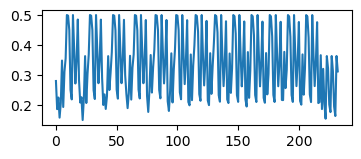

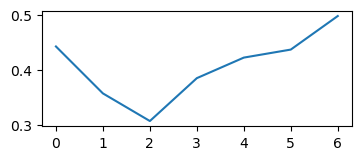

C:\Users\micstaff\mambaforge\envs\convpaint\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\micstaff\mambaforge\envs\convpaint\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\micstaff\mambaforge\envs\convpaint\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


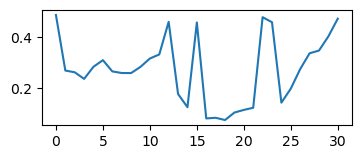

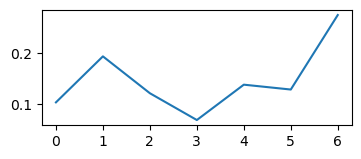

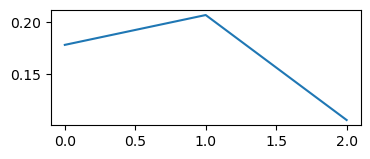

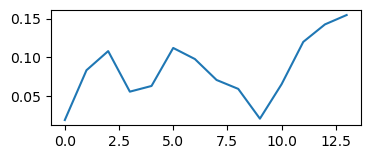

In [181]:
n_proc_frames = 2

pbar = tqdm(datasets, desc='ds', leave=True,
                          postfix={'op':'Init', 'ds': None, 'frame': -1, 'y_crop_idx': -1, 'x_crop_idx': -1}
                         )
for ds in pbar:
    tmpl_img, tmpl_lbl = get_img_lbl_tmpl(data_root, ds)
    st_img = read_stack(tmpl_img, n_max=None)
    st_lbl = read_stack(tmpl_lbl, n_max=None)

    st_img = st_img.astype(np.float32)
    
    mask = st_lbl > 0
    mask_std = np.std(mask, axis=(1, 2))
    
    plt.figure(figsize=(4, 1.5))
    plt.plot(mask_std)
    plt.show()
    plt.close()

    pbar.set_postfix({'op':'Norm', 'ds': ds, 'frame': -1, 'y_crop_idx': -1, 'x_crop_idx': -1})
    st_m, st_s = get_mean_std(st_img)
    st_img -= st_m
    st_img /= st_s
    
    
    ns, h, w = st_img.shape

    idx_of_masks_with_highest_var = np.argsort(mask_std)[::-2]  # every second subsampling
    for i in idx_of_masks_with_highest_var[:n_proc_frames]:
        for j in range(0, h, sz):
            for k in range(0, w, sz):
                pbar.set_postfix({'op':'FeatExtr', 'ds': ds, 'frame': i, 'y_crop_idx': j, 'x_crop_idx': k})
                
                img = st_img[i, j:j+sz, k:k+sz]
                lbl = st_lbl[i, j:j+sz, k:k+sz]
                features_all_samples, targets_all_samples, feature_info = get_features_all_samples_rich(
                    model=model, images=img,
                    annotations=lbl, scalings=[1,2],
                    order=0,
                    add_grad=False, add_rot=False, add_neg=True
                )
                
                if features_all_samples is None:
                    continue
    
                d = {'features': features_all_samples, 'targets': targets_all_samples, 'feature_info': feature_info}
                p = data_root/'features'/ds
                p.mkdir(exist_ok=True, parents=True)
                save_pckl(d, f'features_{i}_{j}_{k}.pckl', path=p)

In [164]:
#d['feature_info']
for k, v in d['feature_info'].items():
    print(k, v[1], v[2], v[6])

0 raw_+_1_1 1 raw
1 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0001 1 orig
2 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0002 1 orig
3 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0003 1 orig
4 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0004 1 orig
5 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0005 1 orig
6 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0006 1 orig
7 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0007 1 orig
8 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0008 1 orig
9 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0009 1 orig
10 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0010 1 orig
11 features.0 Conv2d(3, 64, kernel_size=(

In [67]:
all_features_all_samples = []
all_targets_all_samples = []

for pi in p.glob('*.pckl'):
    d = load_pckl(pi)
    print(d['features'][0].shape)
    features_all_samples, targets_all_samples, feature_info = d['features'][0], d['targets'][0], d['feature_info']
    all_features_all_samples.append(np.asarray(features_all_samples))
    all_targets_all_samples.append(np.asarray(targets_all_samples))
    
all_features_all_samples = np.concatenate(all_features_all_samples, axis=0)
all_targets_all_samples = np.concatenate(all_targets_all_samples, axis=0)

(11342, 1665)
(2432, 1665)
(8598, 1665)
(2994, 1665)
(8674, 1665)
(112, 1665)
(3026, 1665)
(14072, 1665)
(25749, 1665)
(16833, 1665)
(4764, 1665)
(13464, 1665)
(33362, 1665)
(11337, 1665)
(20333, 1665)
(9895, 1665)
(18340, 1665)


In [68]:
all_features_all_samples.shape, all_targets_all_samples.shape

((205327, 1665), (205327,))

In [72]:
norm = all_features_all_samples.std(axis=0)
norm[norm==0] = 1
all_features_all_samples_norm = all_features_all_samples/norm

In [73]:
model.features_per_layer

[64, 256, 512]

In [77]:
all_features_all_samples_norm[:, 1:1+64].shape

(205327, 64)

In [79]:
mapper_1 = umap.UMAP().fit(all_features_all_samples_norm[:, 1:1 + 64])

D:\development\Anaconda\envs\napari_cp2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [80]:
mapper_2 = umap.UMAP().fit(all_features_all_samples_norm[:, 1+64:1+64+256])

D:\development\Anaconda\envs\napari_cp2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
mapper_3 = umap.UMAP().fit(all_features_all_samples_norm[:, 1+64+256:1+64+256+512])

In [ ]:
umap.plot.points(mapper_1)

In [ ]:
umap.plot.points(mapper_1, labels=all_targets_all_samples, theme='fire')

In [ ]:
local_dims = umap.plot.diagnostic(mapper_1, diagnostic_type='local_dim')

In [ ]:
umap.plot.points(mapper_2)

In [ ]:
umap.plot.points(mapper_2, labels=all_targets_all_samples, theme='fire')

In [ ]:
local_dims = umap.plot.diagnostic(mapper_2, diagnostic_type='local_dim')

<AxesSubplot: >

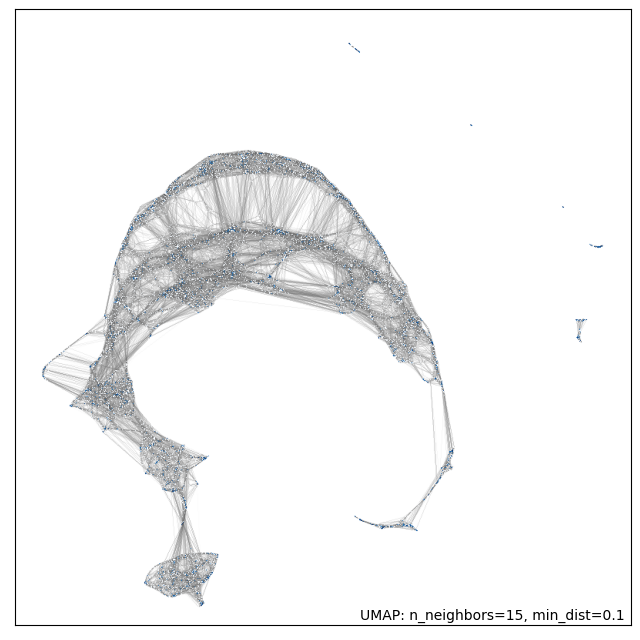

In [65]:
umap.plot.connectivity(mapper, show_points=True)

D:\development\Anaconda\envs\napari_cp2\lib\site-packages\umap\plot.py:885: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot: >

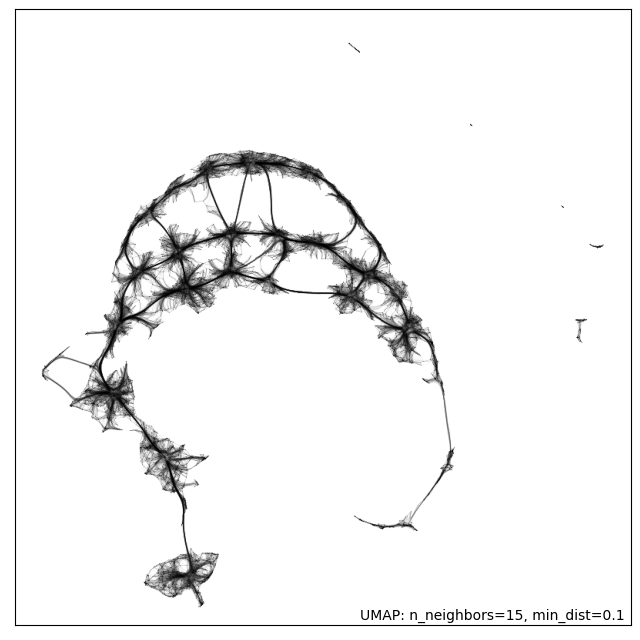

In [66]:
umap.plot.connectivity(mapper, edge_bundling='hammer')

In [21]:
tgts = np.array(targets_all_samples[0])

In [22]:
tgts.shape

(40815,)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, jaccard_score, average_precision_score, confusion_matrix

In [25]:
X, X_test, y, y_test = train_test_split(features_all_samples[0], targets_all_samples[0], 
                                        test_size = 0.2, 
                                        random_state = 42)    

In [26]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, max_leaf_nodes=20)
random_forest.fit(X, y)

RandomForestClassifier()

In [30]:
y_pred = random_forest.predict(X_test)
y_pred_p = random_forest.predict_proba(X_test)

In [31]:
y_pred.shape, y_pred_p.shape

((8163,), (8163, 3))

In [36]:
#calculate precision, recall, accuracy, F1 and IoU, print confusion matrix


print("Accuracy: ", accuracy_score(y_test, y_pred))

print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
# calculate 
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
print("IoU score: ", jaccard_score(y_test, y_pred, average='macro'))

print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))

#calculate average precision score
print('Average precision-recall score: ', average_precision_score(y_test==2, y_pred_p[1]))


Accuracy:  0.9908122013965454
Precision:  0.9360016927749834
Recall:  0.9146213435248928
F1 score:  0.9248198607751609
IoU score:  0.8752817012183152
Confusion matrix: 
 [[4000    0   15]
 [   0 3952   15]
 [   9   36  136]]


ValueError: Found input variables with inconsistent numbers of samples: [8163, 3]

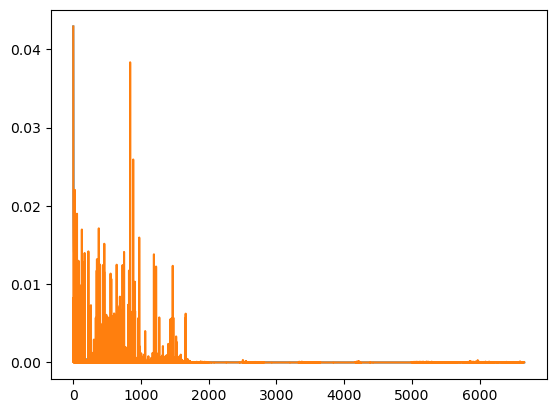

In [39]:
# visualize feature importance
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.plot(importances[indices])
plt.plot(importances)
# Print the feature ranking
# print("Feature ranking:")
# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

(-0.0001, 0.0005)

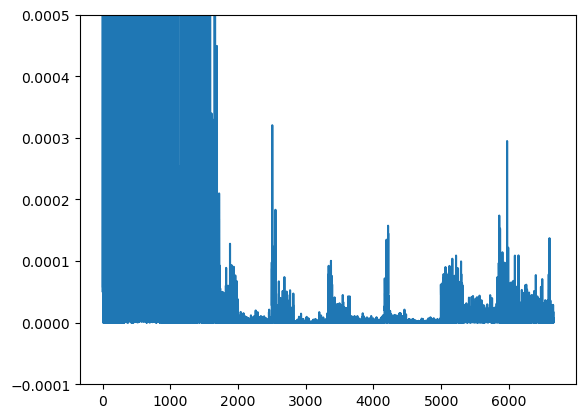

In [48]:
plt.plot(importances)
plt.ylim(-0.0001, 0.0005)

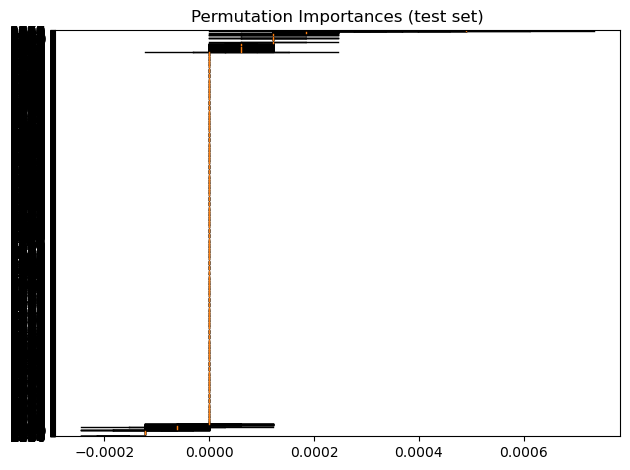

In [40]:
# get permutation importances
from sklearn.inspection import permutation_importance
result = permutation_importance(random_forest, X_test, y_test, n_repeats=2,
                                random_state=42, n_jobs=4)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=indices[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()
    


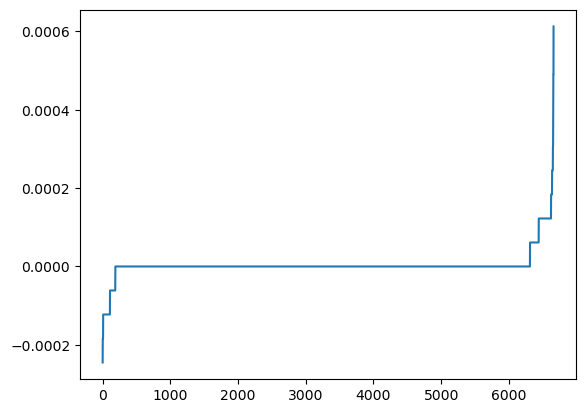

In [45]:
plt.plot(sorted(result.importances_mean))

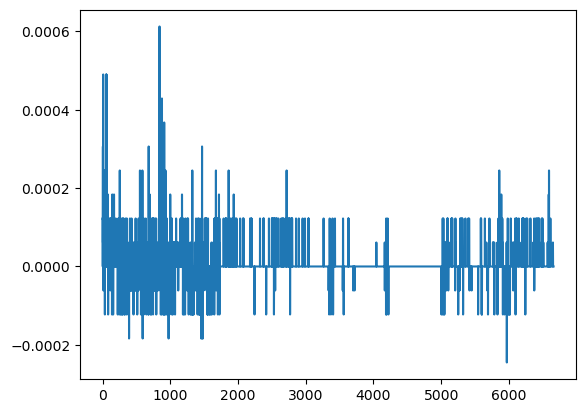

In [44]:
plt.plot(result.importances_mean)

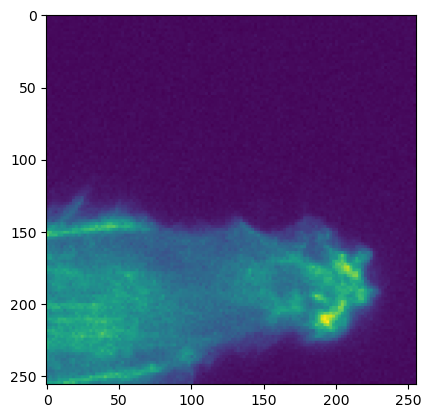

In [31]:
plt.imshow(img)

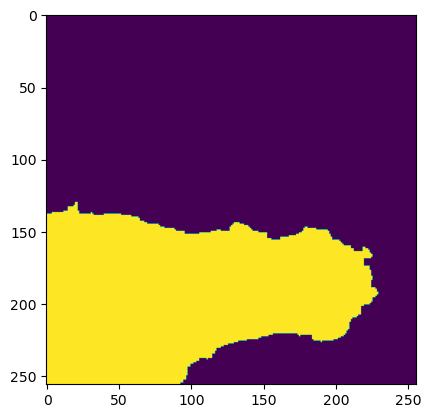

In [32]:
plt.imshow(lbl)

In [48]:
features_all_samples, targets_all_samples, feature_info = get_features_all_samples_rich(
                model=model, images=img, annotations=lbl, scalings=[1,2], order=0)

In [32]:
np.expand_dims([2])

array([[[2]]])

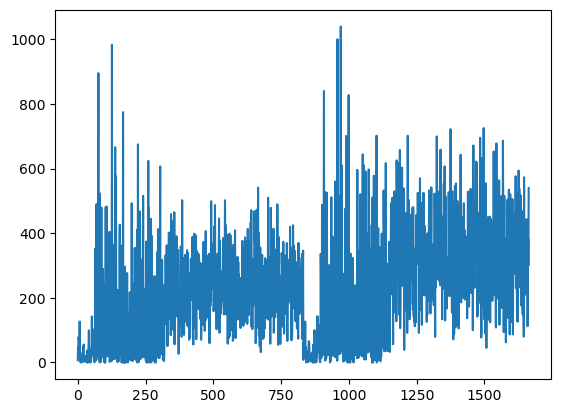

In [23]:
plt.plot(features_std)

The selected output layers have 64 and 256 output features, for a total of 320 features. This matches the number of features of the ```features``` dataframe as shown above. Finally we can train a classifier:

In [ ]:
random_forest = train_classifier(features, targets)

And do a prediction. Note that the same settings as those used for training need to be used here for ```scalings```, ```order``` and ```use_min_features```:

In [ ]:
predicted = predict_image(image, model, random_forest, scalings=[1,2], order=1, use_min_features=False)

And finally we can visualize the output (and quantify its quality):

In [ ]:
viewer.add_labels(predicted);

In [ ]:
nbscreenshot(viewer)